In [1]:
import pandas as pd
#pd.set_option("display.max_colwidth", 200)
#import swifter
import numpy as np
import re
import spacy
import time
import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
#import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the Original March 2020 Review Dataset, Clean Reviews, Build Bigrams and Trigrams

In [3]:
Reviews = pd.read_csv(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Combined_Reviews_March.csv.gz', \
                      compression='gzip', error_bad_lines=False, usecols=['listing_id','review_comments','review_language'])

print(Reviews.shape)
Reviews.head()

(12427274, 3)


listing_id                                    review_comments  \
0     9214018  My family of 6 and 2 dogs have truly enjoyed s...   
1     9214018  The host canceled this reservation 17 days bef...   
2    21109067  Pictures do not do it justice. This place is i...   
3    21109067  It's The perfect house for a stay at the beach...   
4    21109067                     Canât go wrong staying here.   

  review_language  
0              en  
1              en  
2              en  
3              en  
4              en

In [4]:
# Remove all non-english reviews
Reviews = Reviews[(Reviews.review_language.isin(['en']))]
print(Reviews.shape)

(11842232, 3)


In [5]:
# Drop all columns except for listing_id and review comments
Reviews = Reviews[['listing_id', 'review_comments']]
Reviews.head()

listing_id                                    review_comments
0     9214018  My family of 6 and 2 dogs have truly enjoyed s...
1     9214018  The host canceled this reservation 17 days bef...
2    21109067  Pictures do not do it justice. This place is i...
3    21109067  It's The perfect house for a stay at the beach...
4    21109067                     Canât go wrong staying here.

In [6]:
# Remove NaN comments and remove empty ones
Reviews = Reviews[ (Reviews['review_comments'].notnull()) & (Reviews['review_comments'] != '') ]
print(Reviews.shape)

(11839790, 2)


In [17]:
# Remove tags (<><\>), punctuation, multiple whitespaces, numbers, stopwords, words <= 2 chars
from gensim.parsing.preprocessing import preprocess_string,strip_tags,strip_punctuation,strip_multiple_whitespaces,\
                                         strip_numeric,remove_stopwords,strip_short

def pre_process_comments(comment):
    processed_str = gensim.parsing.preprocessing.preprocess_string(comment, filters=[lambda x: x.lower(),strip_tags,\
                                strip_punctuation,strip_multiple_whitespaces,strip_numeric,remove_stopwords,strip_short])
    return processed_str

Reviews['review_comments'] = Reviews['review_comments'].apply(pre_process_comments)

In [13]:
# Build the bigram and trigram models

all_words = Reviews.review_comments.tolist()

bigram = gensim.models.Phrases(all_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[all_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


In [15]:
# Save Bigram and Trigram
bigram_mod.save(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Bigram_March20')
trigram_mod.save(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Trigram_March20')

In [35]:
# Load Bigram and Trigram

bigram_mod = gensim.models.phrases.Phraser.load(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Bigram_March20')
trigram_mod = gensim.models.phrases.Phraser.load(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Trigram_March20')

#for bigram in bigram_mod.phrasegrams.keys():
    #print(bigram)

#for trigram in trigram_mod.phrasegrams.keys():
#    print(trigram)   


In [47]:
# Implement bigram and trigram to all rows
def make_bi_tri_grams(comments):
    
    all_bigrams = bigram_mod[comments]
    all_trigrams = trigram_mod[bigram_mod[all_bigrams]]
    return all_trigrams
    
Reviews['review_comments'] = Reviews['review_comments'].apply(make_bi_tri_grams)

#b = Reviews[0:100].copy()
#b['review_comments'] = b['review_comments'].apply(make_bi_tri_grams)
#print(b.review_comments.tolist())

In [51]:
# Save Pre-processed Dataset
Reviews.to_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Intermediate.pkl.gz',\
                  compression='gzip')

In [8]:
# Retrieve Pre-processed Dataset
Reviews = pd.read_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Intermediate.pkl.gz',\
                  compression='gzip')

In [10]:
print(Reviews.shape)
Reviews.head()

(11839790, 2)


listing_id                                    review_comments
0     9214018  [family, dogs, truly, enjoyed, staying, house,...
1     9214018  [host, canceled_reservation, days, arrival, au...
2    21109067  [pictures, justice, place, incredible, perfect...
3    21109067  [perfect, house, stay, beach, roomy, exception...
4    21109067                          [canât, wrong, staying]

# Take the Review Dataset, Groupby listing_id, Lemmatize, Filter Infrequent Words

In [26]:
# Combine all the reviews for each listing_id
Review_grouped = Reviews.groupby('listing_id').agg(sum).reset_index()

In [31]:
print(Review_grouped.shape)
Review_grouped.head()

(256867, 2)


listing_id                                    review_comments
0         177  [joeâs, place, perfect, need, small, space, ...
1         344  [melissa, place, comfy, feel, helpful, melissa...
2         360  [beautiful, little, place, needed, couldn, bea...
3         364  [town, visit, family, explore, denver, jason, ...
4         590  [jill, thoughtful, friendly, earth, host, stay...

In [35]:
# Remove all listing_id s with blank reviews
Review_grouped = Review_grouped[Review_grouped['review_comments'].str.len() > 0]
Review_grouped.shape

(256821, 2)

In [46]:
# Read list of words, join, lemmatize (lemmatize will split the joined string), return list of words

nlp = spacy.load('en', disable=['parser', 'ner'])
nlp.max_length = 1030000 

def lemmatization(comments):
    
    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
    word_joined = ' '.join([word for word in comments])

    doc = nlp(word_joined)
    output = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return output

Review_grouped['review_comments'] = Review_grouped['review_comments'].apply(lemmatization)

In [55]:
Review_grouped.head()

listing_id                                    review_comments
0         177  [place, perfect, need, small, space, super, ya...
1         344  [place, comfy, feel, helpful, able, accommodat...
2         360  [beautiful, little, place, need, couldn, beat,...
3         364  [town, family, explore, leave, extensive, list...
4         590  [thoughtful, friendly, host, stay, week, long,...

In [49]:
# Save Lemmatized Dataset
Review_grouped.to_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Lemmatized.pkl.gz',\
                          compression='gzip')

In [2]:
# Retrieve Pre-processed Dataset
Review_grouped = pd.read_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Lemmatized.pkl.gz',\
                  compression='gzip')

In [5]:
print(Review_grouped.shape)
Review_grouped.head()

(256821, 2)


listing_id                                    review_comments
0         177  [place, perfect, need, small, space, super, ya...
1         344  [place, comfy, feel, helpful, able, accommodat...
2         360  [beautiful, little, place, need, couldn, beat,...
3         364  [town, family, explore, leave, extensive, list...
4         590  [thoughtful, friendly, host, stay, week, long,...

In [19]:
from nltk import FreqDist

all_comments = Review_grouped.review_comments.tolist()

all_words = [word for comment in all_comments for word in comment]

fdist = FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

In [60]:
print('Unique Words: ',words_df['word'].nunique())

#d = words_df.nlargest(columns="count", n = 1) 

# Create a list of words that appear only once
d = words_df[words_df['count']==1] # <=4 ---> filter out words that appear less than 5 times 

print(d.shape)
d.head()

infreq_words = d.word.tolist()

Unique Words:  231054
(107955, 2)


In [57]:
# Remove words that appear only once
infreq_set = set(infreq_words)

def remove_infreq(comment):
    
    freq_words = list(set(comment).difference(infreq_set))
    
    #freq_words = [word for word in comment if word not in infreq_words] # this is too slow

    return freq_words

Review_grouped['review_comments'] = Review_grouped['review_comments'].apply(remove_infreq)

listing_id                                    review_comments
0         177  [fun, clean, eat, appeal, concept, privacy, sm...
1         344  [large, easy, surround, great, backyard, live,...
2         360  [fun, forget, hopefully, clean, eat, encroach,...
3         364  [fun, forget, pub, clean, afternoon, accommdat...
4         590  [forget, educated, pristine, exhibit, fast, mo...

In [71]:
# Save Filtered Dataset Before Running LDA
Review_grouped.to_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Pre_LDA.pkl.gz',\
                          compression='gzip')

In [61]:
# Check that words were removed correctly
from nltk import FreqDist

all_comments = Review_grouped.review_comments.tolist()

all_words2 = [word for comment in all_comments for word in comment]

fdist2 = FreqDist(all_words2)
words_df2 = pd.DataFrame({'word':list(fdist2.keys()), 'count':list(fdist2.values())})

print('Unique Words: ',words_df2['word'].nunique())

Unique Words:  123099


In [74]:
d2 = words_df2[words_df2['count']<=4]

print(d2.shape)
d2.head()

infreq_words2 = d2.word.tolist()

(66529, 2)


In [75]:
# Remove words that appear <= 4 times
infreq_set2 = set(infreq_words2)

def remove_infreq(comment):
    
    freq_words = list(set(comment).difference(infreq_set2))
    
    #freq_words = [word for word in comment if word not in infreq_words] # this is too slow

    return freq_words

Review_grouped['review_comments'] = Review_grouped['review_comments'].apply(remove_infreq)

In [76]:
# Save Filtered Dataset with word count >= 5 Before Running LDA
Review_grouped.to_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Pre_LDA_Freq5.pkl.gz',\
                          compression='gzip')

#  Create a Dictionary and Run LDA

In [80]:
# Create a list of list
processed_reviews = Review_grouped['review_comments'].tolist()

# Create Dictionary
id2word = corpora.Dictionary(processed_reviews)
print('Total Vocabulary Size:', len(id2word))

# Create Corpus : Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_reviews]

Total Vocabulary Size: 56570


In [83]:
import time

start_time = time.time()

lda_model_50 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=130000,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

end_time = time.time()

print('Time Taken: ',end_time-start_time)

Time Taken:  6422.738878250122


In [85]:
import pickle
pickle.dump(lda_model_50,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_model_50',"wb"))

In [89]:
#from pprint import pprint
#pprint(lda_model_50.show_topics(formatted=False))

# Compute Coherence Score

from gensim.models import CoherenceModel

coherence_model_lda_model_50 = CoherenceModel(model=lda_model_50, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda50 = coherence_model_lda_model_50.get_coherence()
print('Coherence Score: ', coherence_lda50)

Coherence Score:  0.2664555587653874


In [90]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_50, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
46     0.107812  0.142586       1        1  7.138723
3      0.062915  0.020392       2        1  6.079501
5      0.101505  0.044633       3        1  4.836110
31     0.111563  0.245597       4        1  4.356721
27     0.091319  0.042803       5        1  4.024101
29     0.062473 -0.026622       6        1  3.805192
45     0.019004 -0.144100       7        1  3.641692
18     0.042584 -0.091534       8        1  3.548309
42     0.075436  0.014340       9        1  3.378498
44     0.095273  0.054575      10        1  3.343656
7      0.041409 -0.057900      11        1  2.963623
30     0.054295 -0.069638      12        1  2.942226
19     0.079843 -0.012194      13        1  2.851960
24     0.071373 -0.018341      14        1  2.798489
4      0.092162 -0.002109      15        1  2.735911
15     0.078914  0.015853      16        1  2.700657
14     0.078825  0.011086      17        1  2.632183
23     0.102515  0.111678      18        1  2.578897
32     0.083541  0.004614      19        1  2.555829
16     0.085844  0.024564      20        1  2.411528
1      0.059311 -0.088574      21        1  2.391176
33     0.070150 -0.043874      22        1  2.356970
43     0.088596  0.054577      23        1  2.244272
9      0.096954  0.074560      24        1  2.159883
28     0.063542 -0.048334      25        1  2.065773
10     0.040235 -0.059339      26        1  2.042033
41     0.096634  0.046804      27        1  1.828723
37     0.066086 -0.011015      28        1  1.819330
11     0.044541 -0.077351      29        1  1.800077
49     0.085418  0.007452      30        1  1.775879
0      0.067347 -0.048746      31        1  1.528013
17     0.076467 -0.016542      32        1  1.480311
40     0.083575 -0.011184      33        1  1.324704
36     0.069200 -0.046848      34        1  0.871104
35     0.084958 -0.010748      35        1  0.696531
8      0.043444 -0.059971      36        1  0.625561
38     0.026556 -0.079491      37        1  0.499818
22     0.069683 -0.047868      38        1  0.425347
48     0.056216  0.086004      39        1  0.292282
47     0.068107  0.019794      40        1  0.282027
21     0.024420 -0.028779      41        1  0.060457
2     -0.006283  0.001333      42        1  0.031720
39    -0.145432 -0.020699      43        1  0.026214
20    -0.474534  0.098977      44        1  0.009257
34    -0.284574 -0.006293      45        1  0.007941
26    -0.317249  0.001244      46        1  0.006763
6     -0.423810  0.022832      47        1  0.006731
13    -0.444098  0.012675      48        1  0.006065
25    -0.398121 -0.007735      49        1  0.005834
12    -0.425941 -0.023141      50        1  0.005400, topic_info=                Term           Freq          Total Category  logprob  loglift
128             host  204999.000000  204999.000000  Default  30.0000  30.0000
65               day  150747.000000  150747.000000  Default  29.0000  29.0000
15           arrival   91712.000000   91712.000000  Default  28.0000  28.0000
19   automated_poste   33265.000000   33265.000000  Default  27.0000  27.0000
110            great  229178.000000  229178.000000  Default  26.0000  26.0000
..               ...            ...            ...      ...      ...      ...
201           plenty       0.331639  117993.976562  Topic50  -9.2111  -2.9555
8            amenity       0.333040  143273.187500  Topic50  -9.2069  -3.1454
620             sure       0.325118  119772.453125  Topic50  -9.2310  -2.9903
110            great       0.331314  229178.765625  Topic50  -9.2121  -3.6204
1        accommodate       0.323033  124646.382812  Topic50  -9.2374  -3.0367

[4463 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
3497       1  0.003018  abandon
3497       2  0.331961  abandon
3497       3  0.005030  abandon
3497       6  0.001006  abandon
3497       7  0.037220  abandon
...

In [91]:
from gensim.models import CoherenceModel
import pickle

lda_model_25 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=25, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           per_word_topics=True)

pickle.dump(lda_model_25,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_model_25',"wb"))

coherence_model_lda_model_25 = CoherenceModel(model=lda_model_25, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda25 = coherence_model_lda_model_25.get_coherence()
print('Coherence Score: ', coherence_lda25)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_25, corpus, id2word)
vis

#end_time = time.time()

#print('Time Taken: ',end_time-start_time)

Coherence Score:  0.24542344907452784


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.050587 -0.179542       1        1  14.232347
5      0.096027 -0.046866       2        1   8.177697
3      0.052400  0.001637       3        1   6.911729
4      0.078320 -0.025898       4        1   5.994021
14     0.087163 -0.055547       5        1   5.883734
17     0.084712 -0.015256       6        1   5.684450
18     0.049388  0.087096       7        1   5.384630
24     0.086640  0.014715       8        1   4.977679
10     0.077344  0.028823       9        1   4.824429
2      0.095046 -0.019323      10        1   4.641880
16     0.093609 -0.049424      11        1   4.567307
19     0.078686  0.010963      12        1   4.160572
12     0.055417  0.086752      13        1   4.060738
11     0.053383  0.067811      14        1   3.852255
15     0.078731 -0.009504      15        1   3.011841
7      0.054495  0.024077      16        1   2.814053
23     0.074129 -0.051041      17        1   2.773467
1      0.064065  0.062568      18        1   2.759164
20     0.021312  0.098340      19        1   2.557948
22     0.048685  0.051505      20        1   1.213220
0      0.063231 -0.010606      21        1   0.906109
6     -0.097726 -0.026882      22        1   0.387750
8     -0.417657 -0.375441      23        1   0.197027
21    -0.483185  0.153158      24        1   0.018346
13    -0.444804  0.177884      25        1   0.007613, topic_info=                Term           Freq          Total Category  logprob  loglift
128             host  213461.000000  213461.000000  Default   30.000  30.0000
65               day  154375.000000  154375.000000  Default   29.000  29.0000
15           arrival   94999.000000   94999.000000  Default   28.000  28.0000
329             pool   59165.000000   59165.000000  Default   27.000  27.0000
19   automated_poste   37090.000000   37090.000000  Default   26.000  26.0000
..               ...            ...            ...      ...      ...      ...
899          picture       0.045685  111454.031250  Topic25  -11.537  -5.2242
627          totally       0.045685   52065.117188  Topic25  -11.537  -4.4631
229          respond       0.045685  130978.570312  Topic25  -11.537  -5.3857
910          problem       0.045685   83015.468750  Topic25  -11.537  -4.9297
235             safe       0.045685  118097.992188  Topic25  -11.537  -5.2822

[2159 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
339        1  0.263286  absolutely
339        2  0.182967  absolutely
339        3  0.018262  absolutely
339        4  0.077505  absolutely
339        5  0.017804  absolutely
...      ...       ...         ...
6429       8  0.975335       ëë¬
11292      8  0.652448          ì
11292     14  0.271853          ì
11292     25  0.054371          ì
37331     25  0.845355     ìì¹ê

[17945 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 6, 4, 5, 15, 18, 19, 25, 11, 3, 17, 20, 13, 12, 16, 8, 24, 2, 21, 23, 1, 7, 9, 22, 14])

# Use a cutoff Tf-Idf instead of Word Frequency

In [2]:
# Retrieve Pre-processed Dataset
Review_grouped = pd.read_pickle(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\Reviews_Mar20_Lemmatized.pkl.gz',\
                  compression='gzip')

In [3]:
Review_grouped.head()

listing_id                                    review_comments
0         177  [place, perfect, need, small, space, super, ya...
1         344  [place, comfy, feel, helpful, able, accommodat...
2         360  [beautiful, little, place, need, couldn, beat,...
3         364  [town, family, explore, leave, extensive, list...
4         590  [thoughtful, friendly, host, stay, week, long,...

In [20]:
# Create a list of list
#processed_reviews = Review_grouped['review_comments'].tolist()

# Create Dictionary
id2word = corpora.Dictionary(processed_reviews)
print('Total Vocabulary Size:', len(id2word))

# Create Corpus : Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_reviews]

# Create Tf-Idf Model
tfidf = gensim.models.TfidfModel(corpus, id2word = id2word)

Total Vocabulary Size: 231054


In [143]:
# Plot the word counts so that we can compare with the corpus after filtering 
# Word count decreases for the first 5 docs : 147(315), 59(61), 123(496), 314(700), 57(1398)
#for i in range(0,5):
#    print('Doc =',i,' Word Count: ', len(corpus[i]))
#    print(tfidf[corpus[i]])

In [141]:
#filter words with low tf-idf

cut_off = 0.025
#corpus_filtered = corpus

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

In [148]:
# Plot the word counts so that we can compare with the corpus before filtering 
# Word count decreases for the first 5 docs : 147(315), 59(61), 123(496), 314(700), 57(1398)
#for i in range(0,5): 
#    print('Doc =',i,' Word Count: ', len(corpus[i]))
#    print(tfidf[corpus[i]])

#import numpy as np
#num_of_topics = 25
#alpha_ini = (1/num_of_topics)*np.ones(num_of_topics)
#print(alpha_ini)

[0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04]


In [149]:
# LDA with 25 topics and tf-idf cutoff 0.025

from gensim.models import CoherenceModel
import pickle
import time
#import numpy

num_of_topics = 25

start_time = time.time()

lda_model_25 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.01,
                                           per_word_topics=True)

pickle.dump(lda_model_25,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_tfidf_model_25',"wb"))

coherence_model_lda_model_25 = CoherenceModel(model=lda_model_25, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda25 = coherence_model_lda_model_25.get_coherence()
print('Coherence Score: ', coherence_lda25)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_25, corpus, id2word)
vis

end_time = time.time()

print('Time Taken: ',end_time-start_time)

Coherence Score:  0.3264647666113416
Time Taken:  24101.24186873436


In [150]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.218819  0.014648       1        1  10.391159
8      0.159218  0.188640       2        1   8.709030
3      0.023722 -0.025584       3        1   7.788886
24    -0.091156 -0.160387       4        1   7.693332
10    -0.131551  0.119775       5        1   7.341793
6     -0.107685  0.095713       6        1   6.857382
4     -0.199552 -0.042562       7        1   5.824514
19    -0.135996 -0.099496       8        1   5.241007
22    -0.112527  0.028460       9        1   4.997788
21    -0.005526  0.028742      10        1   4.409416
17     0.213929  0.047301      11        1   4.048067
2     -0.127729  0.149935      12        1   3.868953
13    -0.097530  0.132732      13        1   2.805777
14     0.225899 -0.188056      14        1   2.691559
0      0.010868 -0.146677      15        1   2.613967
9     -0.028059 -0.243937      16        1   2.054523
15    -0.038604  0.222523      17        1   1.978401
23    -0.053080 -0.185156      18        1   1.836769
16     0.004379  0.146271      19        1   1.716856
5      0.056295 -0.016893      20        1   1.455967
11    -0.001647 -0.177171      21        1   1.420819
20     0.227808  0.165433      22        1   1.335102
7      0.177393 -0.021013      23        1   1.298139
1      0.229856 -0.041691      24        1   0.860482
12     0.020093  0.008451      25        1   0.760315, topic_info=          Term          Freq         Total Category  logprob  loglift
331       room  1.441086e+06  1.441086e+06  Default  30.0000  30.0000
128       host  2.143448e+06  2.143448e+06  Default  29.0000  29.0000
677  apartment  1.374627e+06  1.374627e+06  Default  28.0000  28.0000
160   location  2.581206e+06  2.581206e+06  Default  27.0000  27.0000
123       home  1.475565e+06  1.475565e+06  Default  26.0000  26.0000
..         ...           ...           ...      ...      ...      ...
261       stay  2.724645e+03  5.607708e+06  Topic25  -5.8343  -2.7504
183       need  2.036015e+03  1.277598e+06  Topic25  -6.1256  -1.5626
108         go  1.707773e+03  2.316264e+05  Topic25  -6.3014  -0.0307
159     locate  1.719121e+03  2.841434e+05  Topic25  -6.2948  -0.2285
103   friendly  1.720899e+03  4.199452e+05  Topic25  -6.2938  -0.6181

[2125 rows x 6 columns], token_table=        Topic      Freq     Term
term                            
103192     10  0.992268    abhay
32609      15  0.997801      abi
0           1  0.021135     able
0           2  0.155554     able
0           3  0.046408     able
...       ...       ...      ...
7695        7  0.001795  zachary
7695        8  0.998028  zachary
96999       5  1.000339    zoila
120206      4  0.999547    zsolt
17946       3  1.005830  âstay

[10845 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[19, 9, 4, 25, 11, 7, 5, 20, 23, 22, 18, 3, 14, 15, 1, 10, 16, 24, 17, 6, 12, 21, 8, 2, 13])

In [5]:
#filter words with low tf-idf

cut_off = 0.075
#corpus_filtered = corpus

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

In [6]:
# LDA with 15 topics and tf-idf cutoff 0.075

from gensim.models import CoherenceModel
import pickle
import time
#import numpy

num_of_topics = 15

start_time = time.time()

lda_model_15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

pickle.dump(lda_model_15,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_tfidf_model_15',"wb"))

coherence_model_lda_model_15 = CoherenceModel(model=lda_model_15, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda15 = coherence_model_lda_model_15.get_coherence()
print('Coherence Score: ', coherence_lda15)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_15, corpus, id2word)

end_time = time.time()
print('Time Taken: ',end_time-start_time)

vis

Coherence Score:  0.37820025339954527
Time Taken:  11711.239094734192


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.182414 -0.080571       1        1  10.605097
4      0.269734 -0.071985       2        1  10.189840
5     -0.119404  0.233251       3        1   9.367000
8     -0.254219 -0.163273       4        1   8.650105
6      0.116174 -0.125435       5        1   8.170135
2     -0.027090 -0.180787       6        1   7.971154
12     0.268812  0.116990       7        1   7.191814
11     0.031415 -0.141302       8        1   6.397190
13    -0.190182  0.075322       9        1   5.389477
14     0.108661  0.211694      10        1   5.299099
9      0.064889  0.038621      11        1   4.430524
0     -0.085548  0.175797      12        1   4.309754
10     0.087951 -0.194429      13        1   4.133704
7     -0.099022  0.058602      14        1   4.114163
3      0.010245  0.047505      15        1   3.780958, topic_info=           Term          Freq         Total Category  logprob  loglift
677   apartment  1.138496e+06  1.138496e+06  Default  30.0000  30.0000
331        room  7.871210e+05  7.871210e+05  Default  29.0000  29.0000
198       place  8.785460e+05  8.785460e+05  Default  28.0000  28.0000
1015       view  4.305970e+05  4.305970e+05  Default  27.0000  27.0000
160    location  5.448700e+05  5.448700e+05  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
42       coffee  1.046692e+04  9.064530e+04  Topic15  -4.5992   1.1165
175      modern  8.023730e+03  5.046036e+04  Topic15  -4.8650   1.4364
173   microwave  4.336813e+03  1.114198e+04  Topic15  -5.4803   2.3316
639      unique  5.222906e+03  2.779069e+04  Topic15  -5.2943   1.6035
797      fridge  4.704767e+03  2.143313e+04  Topic15  -5.3988   1.7588

[1037 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
339        1  0.615381  absolutely
339        3  0.226332  absolutely
339        7  0.126821  absolutely
339       10  0.031399  absolutely
662        1  1.000049  accessible
...      ...       ...         ...
314       12  0.117135        yard
314       15  0.000218        yard
85326      2  1.000400        yoke
42085     10  0.999855     yolanda
15736     10  0.999997      yvonne

[2418 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 6, 9, 7, 3, 13, 12, 14, 15, 10, 1, 11, 8, 4])

In [15]:

topics = [[(term, round(wt, 3)) for term, wt in lda_model_15.show_topic(n, topn=20)] for n in range(0, lda_model_15.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, 21)], \
                         index=['Topic '+str(t) for t in range(1, lda_model_15.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], index=['Topic'+str(t) for t in range(1, lda_model_15.num_topics+1)] )
topics_df

topics_df.head()


Terms_in_Topic
Topic1  hot, cabin, tub, tiny, mountain, property, lake, unique, ski, outdoor, tree, relax, getaway, peaceful, desert, fireplace, town, farm, dog, animal                                   
Topic2  automated_poste, arrival, new, day, stylish, amenity, super, modern, book, quick, awesome, respond, responsive, picture, communication, month, response, minute, excellent, decorate
Topic3  apartment, subway, train, station, philly, line, building, city, spacious, path, flat, basement, emily, block, build, square, ferry, bar, village, blue                             
Topic4  space, private, park, bed, shower, disney, suite, entrance, basement, stylish, orlando, water, universal, coffee, patio, christine, cool, design, modern, outdoor                   
Topic5  place, clean, stay, great, nice, easy, super, definitely, comfortable, check, close, perfect, recommend, quiet, need, bed, cute, airport, night, cozy

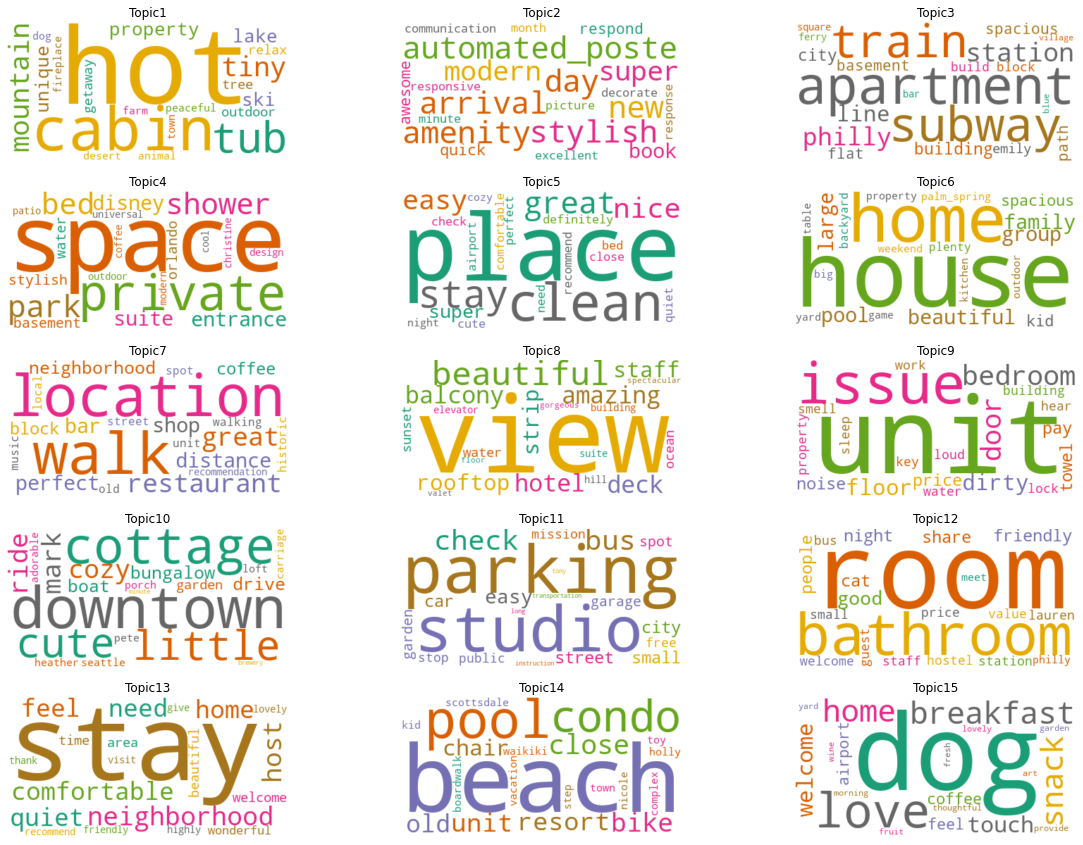

In [19]:
# import wordclouds                      
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(15):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(5, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [21]:
#filter words with low tf-idf

cut_off = 0.05
#corpus_filtered = corpus

for i in range(0, len(corpus)):
    
    bow = corpus[i]
    bow_ids = [id for id, value in bow]
    tfidf_ids = [id for id, value in tfidf[bow]]
    
    low_value_words = [] #reinitialize to be safe. You can skip this.
    low_value_words = [id for id, value in tfidf[bow] if value < cut_off]
    
    #new_bow = [b for b in bow if b[0] not in low_value_words]
    
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] 

    #reassign        
    corpus[i] = new_bow

In [22]:
# LDA with 15 topics and tf-idf cutoff 0.05

from gensim.models import CoherenceModel
import pickle
import time
#import numpy

num_of_topics = 15

start_time = time.time()

lda_model_15 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=65000,
                                           passes=20,
                                           alpha='auto',
                                           eta=0.0001)

#pickle.dump(lda_model_15,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_tfidf_model_15',"wb"))

coherence_model_lda_model_15 = CoherenceModel(model=lda_model_15, texts=processed_reviews, dictionary=id2word, coherence='c_v')
coherence_lda15 = coherence_model_lda_model_15.get_coherence()
print('Coherence Score: ', coherence_lda15)

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_15, corpus, id2word)

end_time = time.time()
print('Time Taken: ',end_time-start_time)

vis

Coherence Score:  0.3603601660511654
Time Taken:  13562.028797626495


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.303974  0.148342  1       1        15.411642
1      0.022556 -0.184522  2       1        9.847108 
3     -0.100465  0.241950  3       1        9.145500 
8     -0.011536 -0.292879  4       1        8.429863 
12    -0.063016  0.216420  5       1        8.354815 
13    -0.253965 -0.088488  6       1        7.863136 
5      0.143113 -0.058378  7       1        6.977548 
6     -0.095380 -0.050860  8       1        6.404937 
10    -0.182155 -0.018487  9       1        6.191832 
2     -0.065038 -0.133064  10      1        5.221363 
14     0.233122  0.120630  11      1        5.153356 
7      0.122288 -0.203351  12      1        4.175856 
9      0.232895  0.107059  13      1        2.936268 
11     0.058866  0.131228  14      1        2.473820 
0      0.262690  0.064402  15      1        1.412955 , topic_info=          Term          Freq         Total Category  logprob  loglift
110  great      2.129850e+06  2.129850e+06  Default  30.0000  30.0000
677  apartment  1.267878e+06  1.267878e+06  Default  29.0000  29.0000
261  stay       2.647588e+06  2.647588e+06  Default  28.0000  28.0000
198  place      2.820099e+06  2.820099e+06  Default  27.0000  27.0000
160  location   1.338602e+06  1.338602e+06  Default  26.0000  26.0000
..        ...            ...           ...      ...      ...      ...
304  weekend    7.355619e+03  7.518562e+04  Topic15 -4.6914   1.9350 
64   cute       8.835391e+03  2.106937e+05  Topic15 -4.5081   1.0878 
155  little     8.817874e+03  2.356111e+05  Topic15 -4.5101   0.9741 
80   dog        6.419332e+03  1.677834e+05  Topic15 -4.8276   0.9961 
82   drive      5.863515e+03  7.559821e+04  Topic15 -4.9181   1.7028 

[1251 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
54090  8      0.996319  abagail   
95354  5      1.000724  abbi      
339    2      0.311792  absolutely
339    3      0.304828  absolutely
339    5      0.000344  absolutely
...   ..           ...         ...
42085  11     1.000224  yolanda   
63585  13     0.999672  yurt      
18575  10     1.000337  yve       
40983  13     0.989812  zach      
40983  14     0.010055  zach      

[3887 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 9, 13, 14, 6, 7, 11, 3, 15, 8, 10, 12, 1])

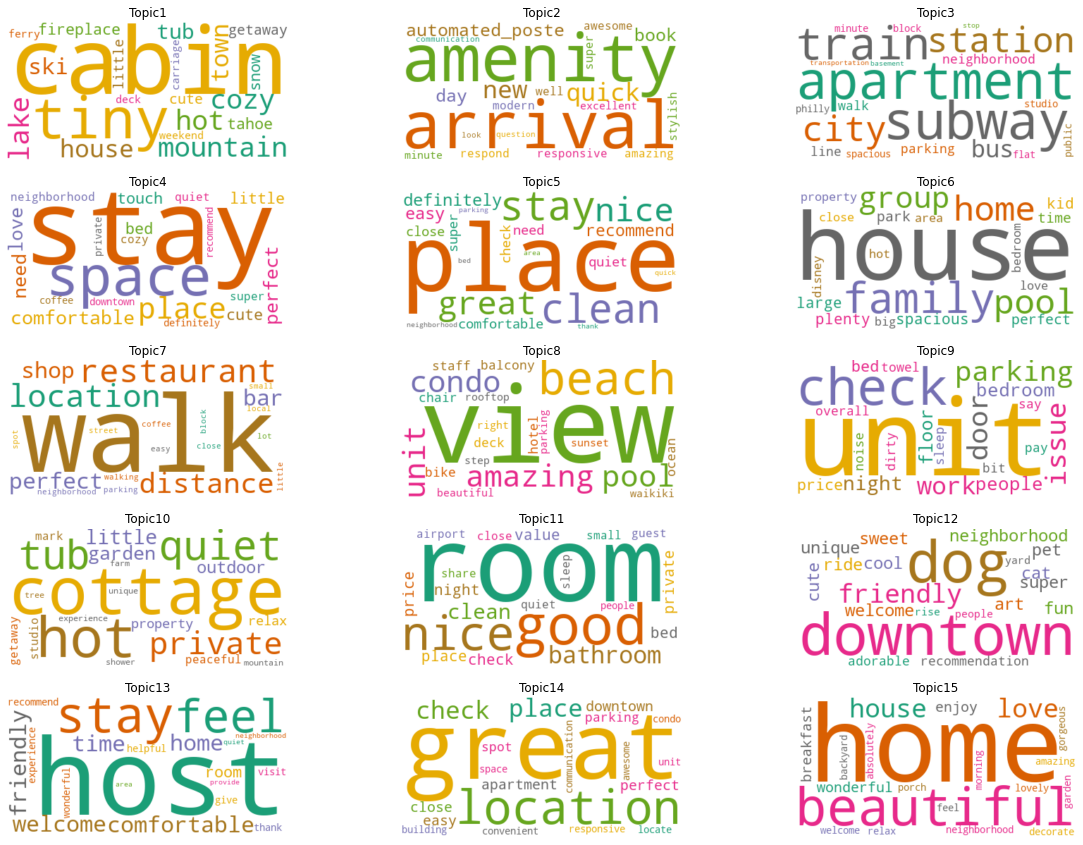

In [23]:
topics = [[(term, round(wt, 3)) for term, wt in lda_model_15.show_topic(n, topn=20)] for n in range(0, lda_model_15.num_topics)]

topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], \
                         columns = ['Term'+str(i) for i in range(1, 21)], \
                         index=['Topic '+str(t) for t in range(1, lda_model_15.num_topics+1)])

#pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms_in_Topic'], index=['Topic'+str(t) for t in range(1, lda_model_15.num_topics+1)] )
topics_df

topics_df.head()

# import wordclouds                      
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(15):

    wc.generate(text=topics_df['Terms_in_Topic'][i])
    
    plt.subplot(5, 3, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [24]:
pickle.dump(lda_model_15,open(r'C:\Users\s137c989\OneDrive - The University of Kansas\Airbnb Shared with Anyi\lda_tfidf_model_15_05',"wb"))